<h1 align="center"><font face = "Times New Roman" size = "80">H.264 Video Kompresi</font></h1>




---



## Pengantar

H.264 merupakan teknik kompresi video dengan format .mp4. Dalam kompresi, menerapkan encoder dan decoder yang berfungsi untuk membandingkan tingkat kompresi yang berbeda dengan memilih berapa banyak bingkai referensi untuk dipilih yang akan memberikan kualitas video. Percobaan ini menggunakan block_size 16 x 16 untuk frame referensi memprediksi frame.


In [1]:
from matplotlib import pyplot as plt
import cv2
import Main as M
from IPython.display import Video # To display the video in the notebook
import numpy as np
import timeit

In [2]:
# Play the video
Video("ub.mp4")

## Kompresi Video

Diagram ini mewakili proses pengkodean. Ada 2 model utama dalam skema ini, yaitu model temporal dan model spasial. Temporal adalah komponen waktu di mana kita menemukan redundansi tertinggi dan di mana letak sebagian besar kompresi. Memanfaatkan redundansi dalam bingkai yang berdekatan dengan cara yang cerdas dan efisien dapat memberikan kemampuan kompresi tinggi dengan sedikit kerusakan pada data. Di sisi lain, model spasial menawarkan cara lain untuk mengompresi data lebih jauh. Ditampilkan di bawah ini adalah diagram blok yang digunakan untuk mengimplementasikan kompresi video. ![video_compression pipeline diagram](images/block_diagram.jpg)

## Metodologi

Dalam blok kode berikut, parameter pengkodean yang berbeda akan digunakan untuk mengeksplorasi keuntungan dari perubahan. Parameter pertama mengontrol akurasi residual dengan menggunakan teknik yang disebut estimasi subpiksel. Teknik ini secara teoritis bekerja dengan melacak perubahan dalam piksel itu sendiri. Parameter kedua mengontrol efisiensi metode kompresi ini dengan menggunakan referensi tunggal untuk beberapa gambar yang diprediksi. Keluaran Bitstream kemudian disimpan di Encoded_BitStream untuk menghitung rasio kompresi algoritme.

Untuk encode dan decode, 2 fungsi utama di Main.py digunakan; yaitu, encode() dan decode(). Kedua fungsi mengatur semua fungsi encoder.py dan decoder.py secara berurutan dengan cara berikut:


### Encoding

#### Teori:
Kompresi video pada umumnya bekerja dengan, alih-alih mengkodekan seluruh bingkai video dan mengirim data pengkodean, info tentang video yang akan membantu regenerasi video untuk dikodekan. Info ini dalam kasus kompresi H264, yang diimplementasikan dalam kode di bawah ini, direpresentasikan melalui vektor gerakan dan residu. Vektor gerak memberikan informasi tentang bagaimana setiap elemen dalam kerangka acuan bergerak. Matriks ini dihitung dengan mengambil satu blok dari kerangka acuan dan mencari blok yang sama di bingkai yang akan datang dan menghitung perubahan indeks di antara 2 blok ini. Informasi ini dikombinasikan dengan kerangka acuan penuh dapat memberikan prediksi kerangka masa depan itu dengan menggerakkan elemen kerangka acuan dengan nilai yang disajikan dalam matriks vektor gerak. Gambar yang diprediksi kemudian dikurangkan dari bingkai masa depan yang sebenarnya untuk menghitung bingkai sisa. Metode ini diinginkan karena energi yang ada dalam matriks ini lebih rendah daripada energi dalam bingkai penuh.
![Motion vector diagram](images/Motion_Vectors.gif)</br>


#### Implementasi:

1. Bingkai video diekstraksi dan dikonversi ke luma dan komponen kroma dari RGB asli.
2. Sebuah kerangka acuan diambil setiap jumlah kerangka yang diberikan.
3. Semua bingkai dipecah menjadi balok-balok agar mudah digunakan dalam fungsi yang akan datang.
4. Vektor gerak kemudian dihitung menggunakan kerangka acuan dan komponen luma kerangka saat ini.
5. Vektor gerak baru kemudian dihitung dari vektor gerak lama untuk memperhitungkan komponen kroma.
6. 3 gambar yang diprediksi diprediksi (luma dan 2 komponen kroma) kemudian dihitung dengan memindahkan blok sesuai dengan vektor gerakan.
7. Residual kemudian dihitung dengan mengurangkan frame yang diprediksi dari frame aktual saat ini.
8. Residu yang dihitung kemudian diteruskan ke fungsi model spasial yang menerapkan fungsi DCT dan kuantisasi pada citra.
9. Keluaran dari model spasial, vektor gerak, dan kerangka acuan kemudian dibinerisasikan
10. Terakhir bitstream dari langkah sebelumnya kemudian diberikan melalui BAC (binary arithmetic encoder)


### Decoding

#### Teori
Proses yang mirip dengan encoder juga dilakukan di decoder. Gambar yang diprediksi dihitung menggunakan vektor gerakan dan bingkai referensi yang didekodekan dari aliran bit. Gambar yang diprediksi kemudian ditambahkan ke residu juga diterjemahkan dari bitstream input. Residu dilewatkan melalui model spasial terbalik sebelum ditambahkan ke gambar yang diprediksi.

#### Implementasi

1. Aliran bit input didekodekan menggunakan dekoder aritmatika biner
2. Aliran bit yang didekodekan kemudian didebinarisasi untuk menghasilkan residu, vektor gerakan, dan kerangka referensi
3. Vektor Gerak diterapkan ke bingkai referensi untuk menampilkan gambar yang diprediksi
4. Matriks sisa dilewatkan melalui model spasial terbalik
5. Gambar yang direkonstruksi diberikan dengan menambahkan residu ke gambar yang diprediksi

## Proses video

In [3]:
# Resolution specifies the depth of the subpixel motion estimation. 
# Resolution 1 means there is not subpixel motion estimation. 
# no_frames specifies the number of frames to be encoded. The first frame will be a reference frame, and the 4 frames will be predicted frames
#Resolution = 1
#no_frames = 5
#start = timeit.default_timer()
#BitStream=M.encode("ub.mp4",5,Resolution)
#OutputVideo=M.decode(Encoded_BitStream,5,Resolution)
#print("Execution time: ", timeit.default_timer() - start)

## Encode video

In [4]:
import julia 
import Encoder as E
jl = julia.Julia()
jl.include('bac.jl')
jl.include('motion_estimation.jl')
path="ub.mp4"
predictedPerRef= 4
no_frames = 10
Resolution=1
vid_frame=E.get_video_frames(path,no_frames,Resolution)
vid_frame=E.interlace_comp_frames(vid_frame)
ref_frames=vid_frame[::predictedPerRef]
n_predicted_frames = no_frames - int(np.ceil(len(vid_frame)/(predictedPerRef+1)))
residual_frames_y = np.zeros((n_predicted_frames, vid_frame[0][0].shape[0], vid_frame[0][0].shape[1]), dtype = int)
residual_frames_cb = np.zeros((n_predicted_frames, vid_frame[0][1].shape[0], vid_frame[0][1].shape[1]), dtype = int)
residual_frames_cr= np.zeros((n_predicted_frames, vid_frame[0][2].shape[0], vid_frame[0][2].shape[1]), dtype = int)

vid_mv = np.zeros((n_predicted_frames, int(vid_frame[0][0].shape[0]/16), int(vid_frame[0][0].shape[1]/16), 2), dtype = int)
c=1
for j in range(0,int(np.ceil(len(vid_frame)/predictedPerRef))):

    #Reshaping the reference frames to use in the coming blocks
    im_ref_y,_,_=E.get_sub_images(E.reshape_image(ref_frames[j][0]))
    im_ref_cb,_,_=E.get_sub_images(E.reshape_image(ref_frames[j][1],8),8)
    im_ref_cr,_,_=E.get_sub_images(E.reshape_image(ref_frames[j][2],8),8)

    if c == n_predicted_frames: break
    for i in range(0,predictedPerRef-1):
        #print(ref_frames[j][0])
        #Reshaping the current frame 
        current_im_blocks, nrows, ncols = E.get_sub_images(E.reshape_image(vid_frame[c][0]))

        #Motion estimation 
        mv = jl.motion_estimation_to_all(ref_frames[j][0], current_im_blocks, nrows, ncols)

        #Motion Compensation
        p_image_y = E.predict(im_ref_y,mv, ref_frames[0][0].shape[0], ref_frames[0][0].shape[1],16)
        mv_cb=np.zeros(mv.shape,dtype=int)
        for x in range(mv.shape[0]):
            for z in range(mv.shape[1]):
                mv_cb[x][z][0]=np.int(mv[x][z][0]/2)
                mv_cb[x][z][1]=np.int(mv[x][z][1]/2)

        p_image_cb=E.predict(im_ref_cb,mv_cb, ref_frames[0][1].shape[0], ref_frames[0][1].shape[1],8)
        p_image_cr=E.predict(im_ref_cr,mv_cb, ref_frames[0][2].shape[0], ref_frames[0][2].shape[1],8)

        #Calculating the residuals
        res_index = int(c - np.ceil(j/predictedPerRef) - 1)
        residual_frames_y[res_index]=E.residual(vid_frame[c][0],p_image_y)
        residual_frames_cb[res_index]=E.residual(vid_frame[c][1],p_image_cb)
        residual_frames_cr[res_index]=E.residual(vid_frame[c][2],p_image_cr)
        
        vid_mv[res_index] = mv
        c+=1
        if(c>len(vid_frame)-1):
            break
    c+=1

# Spatial model
quantized_coeff_y = []
quantized_coeff_cb = []
quantized_coeff_cr = []
for j in range(0,n_predicted_frames):
    quantized_coeff_y.append(E.spatial_model(residual_frames_y[j], 16))
    
    quantized_coeff_cb.append(E.spatial_model(residual_frames_cb[j], 8))
    
    quantized_coeff_cr.append(E.spatial_model(residual_frames_cr[j], 8))

C:\Users\muham\AppData\Local\Programs\Python\Python310\lib\site-packages\julia\core.py:703: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  warnings.warn(
C:\Users\muham\citra digital\Compression\Encoder.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  complete_frame = np.array([frame_Y,frame_Cb1,frame_Cr1,frame_Cb2,frame_Cr2])
C:\Users\muham\AppData\Local\Temp\ipykernel_10808\2787223779.py:41: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify t

In [5]:
(n_predicted_frames)

8

## Informasi mengenai  video

Dimensions of the ref image is  (720, 1280)
Dimensions of the ref divided is (3600, 16, 16)


Text(0.5, 1.0, 'Sample macroblock')

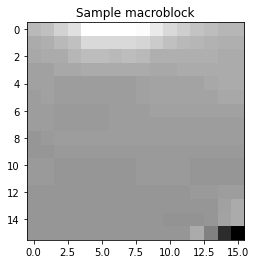

In [6]:
# Print out some statistics about the frames.
import Encoder as e
im_blocks_ref, n_rows, n_cols = e.get_sub_images(e.reshape_image(vid_frame[0][0]))
im_blocks_p, __, __ = e.get_sub_images(e.reshape_image(vid_frame[0][0]))
print('Dimensions of the ref image is ', vid_frame[0][0].shape)
print('Dimensions of the ref divided is', im_blocks_ref.shape)

plt.imshow(im_blocks_ref[1700], "gray")
plt.title("Sample macroblock")

Text(0.5, 1.0, 'Residual frame')

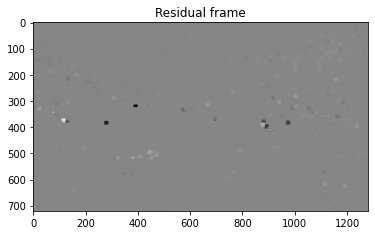

In [7]:
# Print out a sample of the residuals
plt.imshow(residual_frames_y[0], "gray")
plt.title("Residual frame")

## Decode video

In [8]:
# Inverse Spatial model
quantized_residual_y = np.zeros((n_predicted_frames, vid_frame[0][0].shape[0], vid_frame[0][0].shape[1]), dtype = int)
quantized_residual_cb = np.zeros((n_predicted_frames, vid_frame[0][1].shape[0], vid_frame[0][1].shape[1]), dtype = int)
quantized_residual_cr= np.zeros((n_predicted_frames, vid_frame[0][2].shape[0], vid_frame[0][2].shape[1]), dtype = int)
for j in range(0,predictedPerRef-1):
    quantized_residual_y[j] = E.spatial_inverse_model(quantized_coeff_y[j], nrows, ncols, 16)

    quantized_residual_cb[j] =  E.spatial_inverse_model(quantized_coeff_cb[j], nrows, ncols, 8)

    quantized_residual_cr[j] = E.spatial_inverse_model(quantized_coeff_cr[j], nrows, ncols, 8) 
Reconstruced_frames=[]
c=0

# Get predicted image
for j in range(0,np.int(no_frames/predictedPerRef)):
    Reconstruced_frames.append(E.conv_decom_YUV2RGB(E.deinterlace_comp_frames(ref_frames[j])))

    #Reshaping the reference frames to use in the coming blocks
    im_ref_y,_,_=E.get_sub_images(E.reshape_image(ref_frames[j][0]))
    im_ref_cb,_,_=E.get_sub_images(E.reshape_image(ref_frames[j][1],8),8)
    im_ref_cr,_,_=E.get_sub_images(E.reshape_image(ref_frames[j][2],8),8)
    for i in range(0,predictedPerRef-1):
        #inverse spatial
        #residual_blocks, n_rows, n_cols = E.spatial_inverse_model(vid_residuals[c])
        #residual_frame = E.get_reconstructed_image(residual_blocks, n_rows, n_cols)
        mv=vid_mv[c]
        for i in range(mv.shape[0]):
            for j in range(mv.shape[1]):
                mv_cb[i][j][0]=np.int(mv[i][j][0]/2)
                mv_cb[i][j][1]=np.int(mv[i][j][1]/2)
                
        #getting the predicted image
        p_image_y = E.predict(im_ref_y, mv, ref_frames[0][0].shape[0], ref_frames[0][0].shape[1])
        p_image_cb = E.predict(im_ref_cb, mv_cb, ref_frames[0][1].shape[0], ref_frames[0][1].shape[1], 8)
        p_image_cr = E.predict(im_ref_cr, mv_cb, ref_frames[0][2].shape[0], ref_frames[0][2].shape[1], 8)
        
        #adding the residuals to get the reconstructed image
        Reconstructed_y = p_image_y + quantized_residual_y[c]
        Reconstructed_cb = p_image_cb + quantized_residual_cb[c]
        Reconstructed_cr = p_image_cr + quantized_residual_cr[c]

        Reconstructed_interlaced=[Reconstructed_y,Reconstructed_cb,Reconstructed_cr]
        Reconstruced_frames.append(E.conv_decom_YUV2RGB(E.deinterlace_comp_frames(Reconstructed_interlaced)))
        c+=1

C:\Users\muham\AppData\Local\Temp\ipykernel_10808\2018358414.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for j in range(0,np.int(no_frames/predictedPerRef)):
C:\Users\muham\AppData\Local\Temp\ipykernel_10808\2018358414.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, che

## Membuat bingkai dari video yang direkonstruksi

Text(0.5, 1.0, 'last predicted frame')

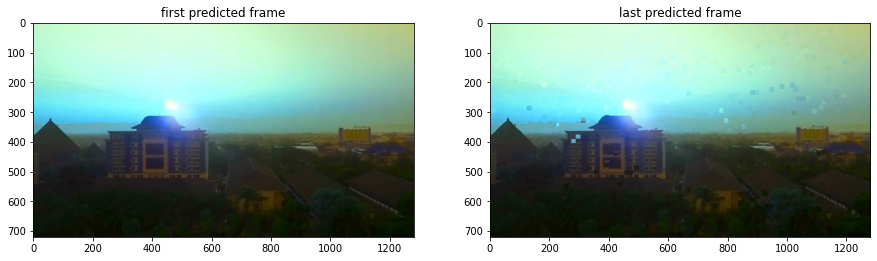

In [9]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (15,15))

ax1.imshow(Reconstruced_frames[0])
ax1.set_title("first predicted frame")


ax2.imshow(Reconstruced_frames[7])
ax2.set_title("last predicted frame")

Text(0.5, 1.0, 'last reference frame')

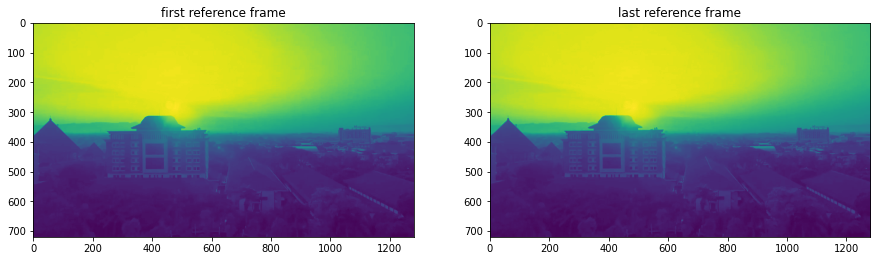

In [10]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (15,15))

ax1.imshow(ref_frames[0][0])
ax1.set_title("first reference frame")


ax2.imshow(ref_frames[2][0])
ax2.set_title("last reference frame")

In [11]:
# Amount of compression achieved
imarr = e.reshape_image(vid_frame[0][0])

#Compute the number of bits of the np array image
size_before = imarr.size * imarr.itemsize * 8 
print("Size in bits of image before compression: ", size_before)

#size_after = []
#for i in range(len(data)):
#    size_after.append(len(data[i]))
    
#print("Size in bits of image after compression: ", size_after)

Size in bits of image before compression:  7372800


## Analisis

Kita dapat melihat bahwa kualitas gambar menurun seiring dengan bertambahnya jumlah gambar yang diprediksi. Hal ini diperkirakan karena perubahan yang terjadi dari frame 1 ke frame 2 lebih kecil daripada perubahan yang terjadi dari frame 1 ke frame 5. Oleh karena itu, kemampuan memprediksi frame menjadi kurang akurat. Untuk mengukur rasio kompresi untuk setiap gambar, ukuran video dihitung dalam bit dengan mengalikan ukuran elemen tunggal dalam array dengan jumlah elemen di seluruh gambar. Adapun gambar yang dikodekan, ukurannya dihitung dengan mencari panjang keluaran BAC. Ukuran gambar kemudian dibagi dengan aliran bit untuk menghitung rasio kompresi. Selain itu, jumlah FLOP dihitung dengan menghitung waktu untuk seluruh operasi kompresi dibagi dengan waktu untuk satu kegagalan.

## Mengubah bingkai keluaran menjadi video

In [12]:
# Save reconstructed images in frames folder

# importing os module   
import os 

# convert the reference frame to RGB
c = 0 
for i in range(len(ref_frames)):
    ref_interlaced=[ref_frames[i][0],ref_frames[i][1],ref_frames[i][2]]
    ref_frame = E.conv_decom_YUV2RGB(E.deinterlace_comp_frames(ref_interlaced))
    # Add the reference frame to the frames folder
    filename = "frames/" + str(i+c) + ".jpg"
    cv2.imwrite(filename, ref_frame)
    i = i+c
    if (i == no_frames): break
    # add the reconstructed frames to the list of saved frames.
    for j in range(predictedPerRef):
        filename = "frames/" + str(j+i+1) + ".jpg"
        cv2.imwrite(filename, Reconstruced_frames[j+c])
    c+=4


In [13]:
# Read the frames in the form of a video

####################
# For a better view of the reconstructed video, view the frames, frame by frame.
####################
image_folder = 'frames'
video_name = 'output_video.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()